# CIFAR-10 \~\~\~My Best Version\~\~\~
This is a notebook which classified CIFAR-10 by using google colaboratory.<br>
Test accuracy was 95.26 %.<br>
## Summary
* Accelerator: GPU
* Data Augmentation: Affine Transformation, Channel Shift, Cutmix
* Model: Dual Path Network, (Conv-BN)x10 - MaxPool - (Conv-BN)x9 - MaxPool - (Conv-BN)x9 - GAP - Dropout - Dense - Dropout - Dense
* Training: epochs<=300, batch_size=64, optimizer=Adam, Reduce Learning Rate
* Test Time Augmentation: epochs=20

Mount My Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

work_dir = "/content/drive/My Drive/Colab Notebooks/cifar10/"

Mounted at /content/drive


Import modules

In [ ]:
!pip install visualkeras
from visualkeras import layered_view

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import cv2

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict

import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.losses import categorical_crossentropy

print('tensorflow varsion:', tf.__version__)
print(tf.test.gpu_device_name())

tensorflow varsion: 2.4.1
/device:GPU:0


# Load and check data

Load data

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
len(classes)

10

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


Check data

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [ ]:
np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test)

(0, 255, 0, 255)

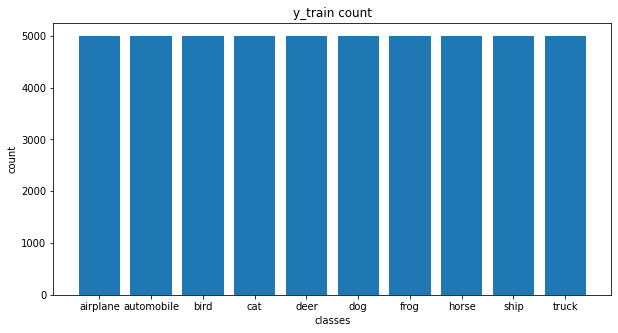

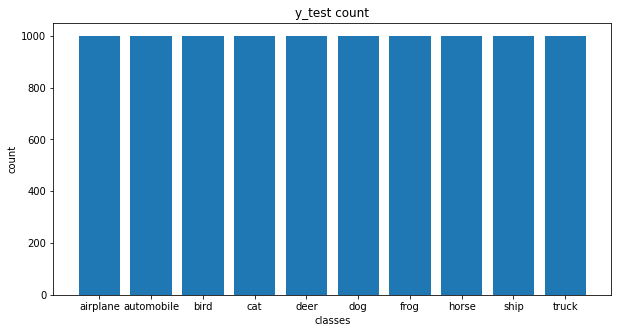

In [ ]:
def plot_count(y, classes=None, title='y count'):
    plt.figure(figsize=(10,5))
    counter_y = [(key, value) for key, value in Counter(y).items()]
    counter_y.sort(key=lambda x: x[0])
    if classes is None:
        classes = [key for key, value in counter_y]
    values = [value for key, value in counter_y]
    plt.bar(classes, values)
    plt.xlabel('classes')
    plt.ylabel('count')
    plt.title(title)
    plt.show()

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

plot_count(y_train, classes, title='y_train count')
plot_count(y_test, classes, title='y_test count')

In [ ]:
# show 10 images
def show_images(X, y_true=np.zeros(10), y_pred=None, classes=defaultdict(str)):
    plt.figure(figsize=(10,5))
    for i in range(min(10, X.shape[0], y_true.shape[0])):
        plt.subplot(2,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        # plot image
        try:
            plt.imshow(X[i], cmap=plt.cm.binary)
        except:
            plt.imshow(np.reshape(X[i],(X.shape[1],X.shape[2])), cmap=plt.cm.binary)

        # show y_true
        label = ''
        if len(y_true.shape) == 1:
            label += classes[y_true[i]]
        elif len(y_true.shape) == 2:
            label_rate = np.argsort(y_true[i])[::-1]
            if y_true[i][label_rate[0]] > 0.99:
                label = classes[label_rate[0]]
            else:
                label += classes[label_rate[0]] + ': ' + f'{y_true[i][label_rate[0]]:.2f}'
                label += '\n' + classes[label_rate[1]]+': ' + f'{y_true[i][label_rate[1]]:.2f}'
                
        # show y_pred
        if y_pred is None:
            plt.xlabel(label)
            continue

        plt.ylabel('Answer: ' + label)
        label = 'Prediction\n'
        if len(y_pred.shape) == 1:
            label += classes[y_pred[i]]
        elif len(y_pred.shape) == 2:
            label_rate = np.argsort(y_pred[i])[::-1]
            label += classes[label_rate[0]] + ': ' + f'{y_pred[i][label_rate[0]]:.2f}'
            if y_pred[i][label_rate[1]] > 0.01:
                label += '\n' + classes[label_rate[1]]+': ' + f'{y_pred[i][label_rate[1]]:.2f}'
        plt.xlabel(label)

    plt.show()

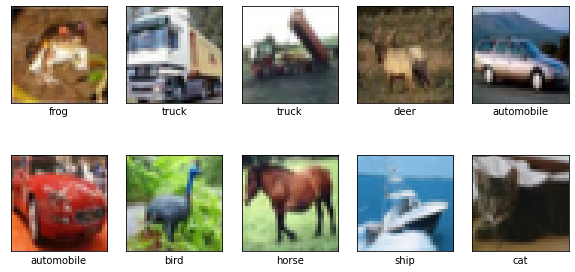

In [ ]:
show_images(X_train, y_train, classes=classes)

# Preprocess data

Normalize images

In [ ]:
X_train = X_train / 255
X_test = X_test / 255
np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test)

(0.0, 1.0, 0.0, 1.0)

Change shapes

In [ ]:
y_train = keras.utils.to_categorical(y_train, len(classes))
y_test = keras.utils.to_categorical(y_test, len(classes))

train_test_split

In [ ]:
validation_seed = 0
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=validation_seed)

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
(40000, 10) (10000, 10) (10000, 10)


# Augment data

In [ ]:
class MyImageDataGenerator:
    def __init__(self, function_on_a_image=None, function_on_two_batches=None):
        self.function_on_a_image = function_on_a_image
        self.function_on_two_batches = function_on_two_batches

    # You can use flow_with_labels when you train a model.
    def flow_with_labels(self, x, y, batch_size=32, shuffle=True):
        assert x.shape[0] == y.shape[0]
        steps = x.shape[0] // batch_size

        # get one batch for mix
        if self.function_on_two_batches is not None:
            prev_X_batch = x[-batch_size:].copy()
            if self.function_on_a_image is not None:
                prev_X_batch = np.array([
                                self.function_on_a_image(img) for img in prev_X_batch])
            prev_y_batch = y[-batch_size:]
        
        # flow
        while True:
            # shuffle
            if shuffle:
                perm = np.random.permutation(x.shape[0])
                x = x[perm]
                y = y[perm]
            
            # augment images
            for step in range(steps):
                X_batch = x[step*batch_size:(step+1)*batch_size].copy()
                y_batch = y[step*batch_size:(step+1)*batch_size].copy()
                if self.function_on_a_image is not None:
                    X_batch = np.array([self.function_on_a_image(img) for img in X_batch])
                if self.function_on_two_batches is not None:
                    X_batch, y_batch, prev_X_batch, prev_y_batch =\
                        self.function_on_two_batches(
                        prev_X_batch, prev_y_batch, X_batch, y_batch)
                yield X_batch, y_batch
    
    # You can use flow_without_labels in test time augmentation.
    def flow_without_labels(self, x, batch_size=100):
        assert x.shape[0] % batch_size == 0
        steps = x.shape[0] // batch_size
        cnt = 0
        while True:
            for step in range(steps):
                X_batch = x[step*batch_size:(step+1)*batch_size].copy()
                X_batch = np.array([self.function_on_a_image(img) for img in X_batch])
                yield X_batch
            yield None


# functions on a img
def color_shift(img, intensity=0.1):
    intensity = np.random.uniform(-intensity, intensity, (1,1,3))
    img = img + intensity
    img = np.clip(img, 0.0, 1.0)
    return img


def affine_transformation(img):
    ### arguments
    flags = cv2.INTER_LINEAR#cv2.INTER_NEAREST#
    borderMode = cv2.BORDER_REPLICATE#cv2.BORDER_CONSTANT#

    rotate_and_zoom_rate = 0.75#0.0#
    rotate_angle = (-20.0, 20.0)#(-0.0,0.0)#
    scale_range = (0.75, 1.25)#(1.0,1.0)#

    parallel_translation_rate = 0.75#0.0#
    width_shift_range = 0.1#0.2#
    height_shift_range = 0.1#0.2#

    horizontal_flip_rate = 0.5#0.0#
    vertical_flip_rate = 0.0#0.5#
    rotate_90_rate = 0.0#0.5#      
    ###
    height = img.shape[0]
    width = img.shape[1]
    center = (height//2, width//2)

    # rotate and zoom
    if 0.0 < rotate_and_zoom_rate and np.random.rand() < rotate_and_zoom_rate:
        angle = np.random.uniform(rotate_angle[0], rotate_angle[1])
        scale = np.random.uniform(scale_range[0], scale_range[1])
        mat = cv2.getRotationMatrix2D(center, angle, scale)
        img = cv2.warpAffine(img, mat, (width, height),
                             flags=flags, borderMode=borderMode)

    # parallel translation
    if 0.0 < parallel_translation_rate and np.random.rand() < parallel_translation_rate:
        width_shift = int(width*width_shift_range)
        height_shift = int(height*height_shift_range)
        dx = np.random.randint(-width_shift, width_shift+1)
        dy = np.random.randint(-height_shift, height_shift+1)
        src_pts = np.array([[0,0], [0,height], [width, 0]], dtype=np.float32)
        dst_pts = np.array([[dx,dy], [dx,height+dy], [width+dx,dy]], dtype=np.float32)
        mat = cv2.getAffineTransform(src_pts, dst_pts)
        img = cv2.warpAffine(img, mat, (width, height),
                             flags=flags, borderMode=borderMode)
    
    # horizontal flip
    if 0.0 < horizontal_flip_rate and np.random.rand() < horizontal_flip_rate:
        img = cv2.flip(img, 1)

    # vertical flip
    if 0.0 < vertical_flip_rate and np.random.rand() < vertical_flip_rate:
        img = cv2.flip(img, 0)
    
    # rotate 90 degrees
    if 0.0 < rotate_90_rate and np.random.rand() < rotate_90_rate:
        if np.random.rand() < 0.5:
            img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        else:
            img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

    return img


# functions on two batches
def cutmix(X1, y1, X2, y2, alpha=0.5):
    h, w = X1.shape[1], X1.shape[2]
    beta = np.random.beta(alpha, alpha, X1.shape[0])
    beta = np.array([min(i, 1-i) for i in beta])
    sqrt_beta = np.sqrt(beta)

    for i in range(X1.shape[0]):
        mask_h = int(h * sqrt_beta[i])
        mask_w = int(w * sqrt_beta[i])

        top = np.random.randint(0, h-mask_h+1)
        left = np.random.randint(0, w-mask_w+1)

        X1[i][top:top+mask_h, left:left+mask_w, :] = X2[i][top:top+mask_h, left:left+mask_w, :]
    
    beta = np.expand_dims(beta, -1)
    y1 = (1-beta)*y1 + beta*y2
    return X1, y1, X2, y2

In [ ]:
def function_on_a_image(img):
    return color_shift(affine_transformation(img))

datagen = MyImageDataGenerator(function_on_a_image, cutmix)

Before Augmentation


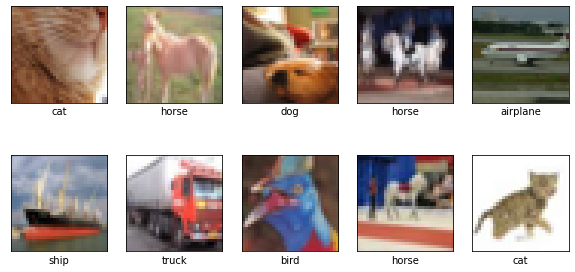

In [ ]:
print('Before Augmentation')
show_images(X_train, y_train, classes=classes)

After Augmentation


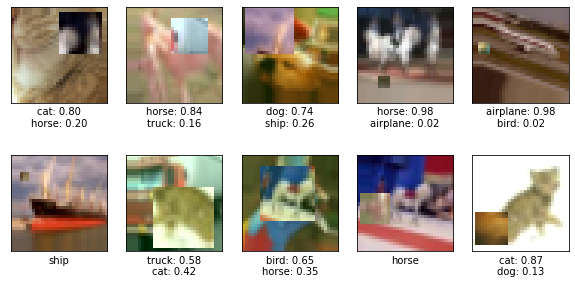

In [ ]:
print('After Augmentation')
for X_aug, y_aug in datagen.flow_with_labels(X_train[:10], y_train[:10], batch_size=10):
    show_images(X_aug, y_aug, classes=classes)
    break

In [ ]:
%%timeit -r 5
def measure_time(datagen_flow, steps):
    cnt = 0
    for X_aug, y_aug in datagen_flow:
        cnt += 1
        if cnt == steps:
            break

measure_time(datagen.flow_with_labels(X_train, y_train, batch_size=64), 625)

1 loop, best of 5: 4.77 s per loop


# Create model

In [ ]:
# Dual Path Networks
def create_model(input_shape, num_classes):
    inputs = Input(input_shape)

    x = Conv2D(32, (3,3), activation='relu')(inputs)
    y = BatchNormalization()(x)

    x = Conv2D(32, (3,3), activation='relu', padding='same')(y)
    z = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(z)
    x = BatchNormalization()(x)
    y = add([x, y])

    for _ in range(3):
        x = Conv2D(32, (3,3), activation='relu', padding='same')(y)
        x = BatchNormalization()(x)
        z = add([z, x])
        x = Conv2D(32, (3,3), activation='relu', padding='same')(z)
        x = BatchNormalization()(x)
        y = add([x, y])

    x = Conv2D(64, (3,3), activation='relu')(y)
    x = MaxPooling2D(pool_size=(2,2))(x)
    y = BatchNormalization()(x)

    x = Conv2D(64, (3,3), activation='relu', padding='same')(y)
    z = BatchNormalization()(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(z)
    x = BatchNormalization()(x)
    y = add([x, y])

    for _ in range(3):
        x = Conv2D(64, (3,3), activation='relu', padding='same')(y)
        x = BatchNormalization()(x)
        z = add([z, x])
        x = Conv2D(64, (3,3), activation='relu', padding='same')(z)
        x = BatchNormalization()(x)
        y = add([x, y])

    x = Conv2D(128, (3,3), activation='relu')(y)
    x = MaxPooling2D(pool_size=(2,2))(x)
    y = BatchNormalization()(x)

    x = Conv2D(128, (3,3), activation='relu', padding='same')(y)
    z = BatchNormalization()(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(z)
    x = BatchNormalization()(x)
    y = add([x, y])

    for _ in range(3):
        x = Conv2D(128, (3,3), activation='relu', padding='same')(y)
        x = BatchNormalization()(x)
        z = add([z, x])
        x = Conv2D(128, (3,3), activation='relu', padding='same')(z)
        x = BatchNormalization()(x)
        y = add([x, y])

    x = Conv2D(256, (3,3), activation='relu')(y)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)

    x = Dropout(0.25)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

model = create_model(input_shape=X_train[0].shape, num_classes=len(classes))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 30, 30, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 30, 30, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 30, 32)   9248        batch_normalization[0][0]        
______________________________________________________________________________________________

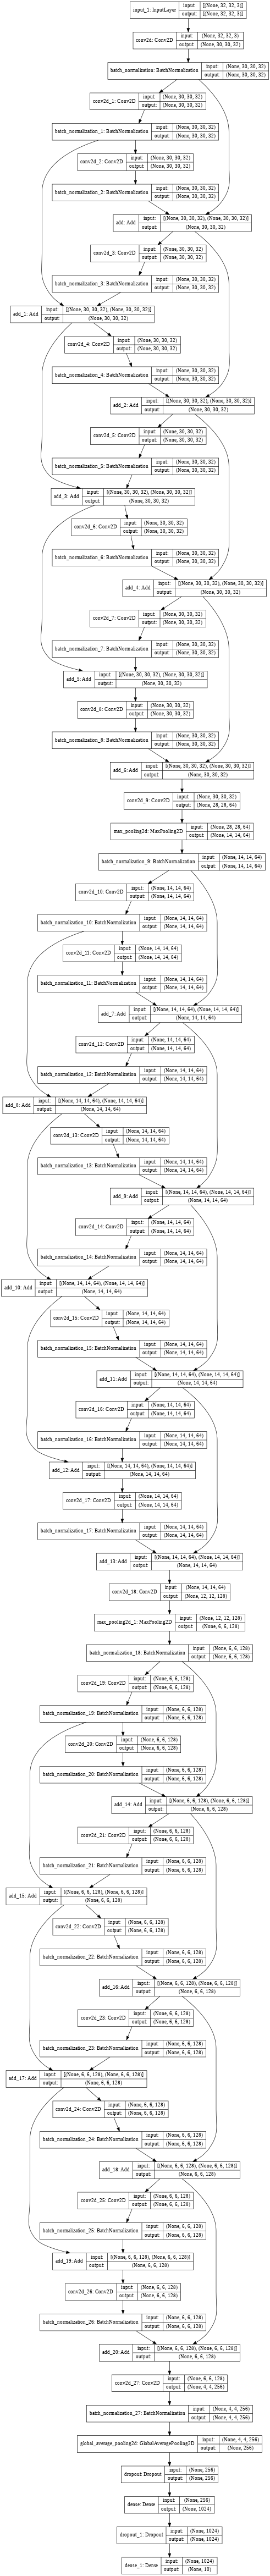

In [ ]:
plot_model(model, show_shapes=True, dpi=48)

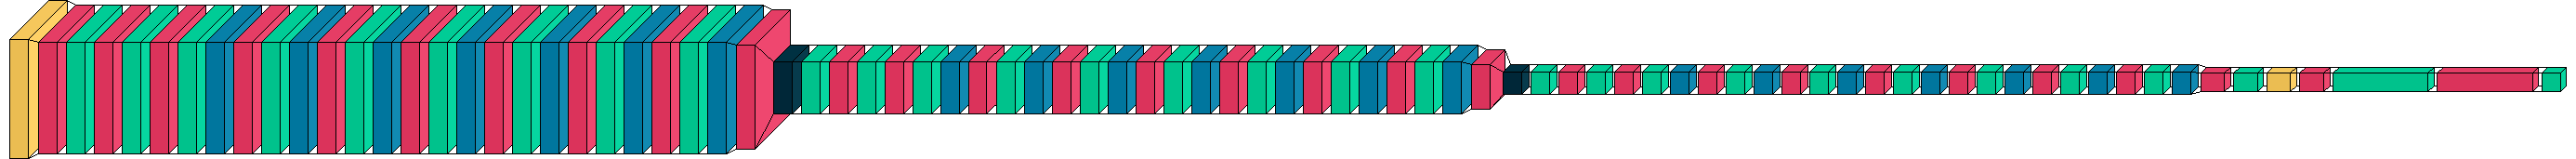

In [ ]:
layered_view(model)

# Train model

In [ ]:
weights_file_name = "best_weights(seed={}).hdf5".format(validation_seed)
model_file_name = "best_model(seed={}).h5".format(validation_seed)

In [ ]:
%%time

save_weights = ModelCheckpoint(filepath=os.path.join(work_dir, weights_file_name),
                                verbose=0, save_best_only=True, save_weights_only=True,
                                monitor='val_loss', mode='min')

early_stop = EarlyStopping(monitor='val_loss', mode='min',
                                patience=15, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min',
                                factor=0.8, patience=5, verbose=1)

model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])

batch_size = 64
epochs = 300

history = model.fit(datagen.flow_with_labels(X_train, y_train, batch_size),
                    validation_data=(X_valid, y_valid),
                    epochs=epochs,
                    steps_per_epoch=X_train.shape[0]//batch_size,
                    verbose=2,
                    callbacks=[save_weights, early_stop, reduce_lr])

model.save(os.path.join(work_dir, model_file_name))

Epoch 1/300
625/625 - 32s - loss: 1.9714 - accuracy: 0.3004 - val_loss: 1.3562 - val_accuracy: 0.5198
Epoch 2/300
625/625 - 22s - loss: 1.7022 - accuracy: 0.4290 - val_loss: 1.4060 - val_accuracy: 0.5121
Epoch 3/300
625/625 - 23s - loss: 1.5792 - accuracy: 0.4854 - val_loss: 1.1338 - val_accuracy: 0.6162
Epoch 4/300
625/625 - 23s - loss: 1.5142 - accuracy: 0.5157 - val_loss: 0.8542 - val_accuracy: 0.7072
Epoch 5/300
625/625 - 23s - loss: 1.4535 - accuracy: 0.5446 - val_loss: 0.8582 - val_accuracy: 0.7100
Epoch 6/300
625/625 - 23s - loss: 1.4137 - accuracy: 0.5644 - val_loss: 0.7454 - val_accuracy: 0.7485
Epoch 7/300
625/625 - 23s - loss: 1.3699 - accuracy: 0.5813 - val_loss: 0.6837 - val_accuracy: 0.7704
Epoch 8/300
625/625 - 23s - loss: 1.3420 - accuracy: 0.5928 - val_loss: 0.7558 - val_accuracy: 0.7490
Epoch 9/300
625/625 - 23s - loss: 1.3073 - accuracy: 0.6095 - val_loss: 0.5887 - val_accuracy: 0.8060
Epoch 10/300
625/625 - 23s - loss: 1.2779 - accuracy: 0.6219 - val_loss: 0.6308 - 

Plot history

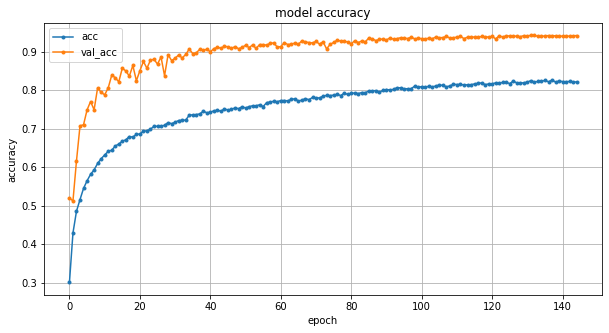

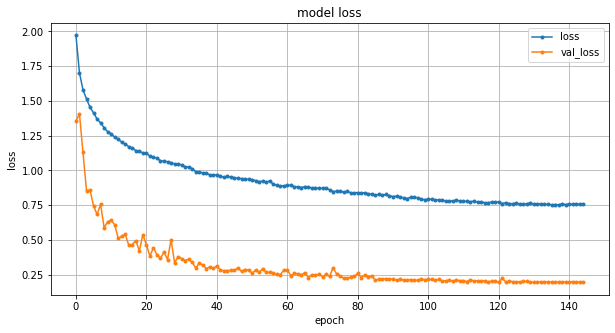

In [ ]:
def plot_history(history):
    # plot accuracy
    plt.figure(figsize=(10,5))
    plt.plot(history.history['accuracy'], marker='.', label='acc')
    plt.plot(history.history['val_accuracy'], marker='.', label='val_acc')
    plt.title('model accuracy')
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.show()

    # plot loss
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], marker='.', label='loss')
    plt.plot(history.history['val_loss'], marker='.', label='val_loss')
    plt.title('model loss')
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.show()

plot_history(history)

# Augment validation data

In [ ]:
model.load_weights(os.path.join(work_dir, weights_file_name))
model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])

In [ ]:
def test_time_augmentation(model, datagen_flow, steps, epochs=10):
    y_pred = model.predict(datagen_flow, steps=steps)
    for _ in range(epochs-1):
        y_pred += model.predict(datagen_flow, steps=steps)
    return y_pred / epochs


def calculate_loss_and_acc(y_test, y_pred):
    loss = np.average(categorical_crossentropy(y_test, y_pred))
    if len(y_test.shape) == 2:
        y_test = np.argmax(y_test, axis=1)
    if len(y_pred.shape) == 2:
        y_pred = np.argmax(y_pred, axis=1)
    acc = np.average(np.equal(y_test, y_pred))
    print('loss:', loss, 'acc:', acc)


def show_mistaken_images(X_test, y_test, y_pred, classes):
    miss_X = []
    miss_y_test = []
    miss_y_pred = []
    for i in range(y_test.shape[0]):
        if np.argmax(y_test[i]) != np.argmax(y_pred[i]):
            miss_X.append(X_test[i])
            miss_y_test.append(y_test[i])
            miss_y_pred.append(y_pred[i])
            if len(miss_X) == 10:
                break
    miss_X = np.array(miss_X)
    miss_y_test = np.array(miss_y_test)
    miss_y_pred = np.array(miss_y_pred)
    show_images(miss_X, miss_y_test, miss_y_pred, classes)


def plot_confusion_matrix(y_test, y_pred, classes):
    if len(y_test.shape) == 2:
        y_test = np.argmax(y_test, axis=1)
    if len(y_pred.shape) == 2:
        y_pred = np.argmax(y_pred, axis=1)

    cmx = confusion_matrix(y_test, y_pred)
    vmax = np.sort(np.ravel(cmx))[-len(classes)-1]
    cmx = pd.DataFrame(cmx, index=classes, columns=classes)

    plt.figure(figsize=(10,10))
    sns.heatmap(cmx, vmax=vmax, annot=True, square=True, cmap='Blues')
    plt.xlabel('prediction class')
    plt.ylabel('answer class')
    plt.title('confusion matrix')
    plt.show()

In [ ]:
tta_datagen = datagen

Before Augmentation


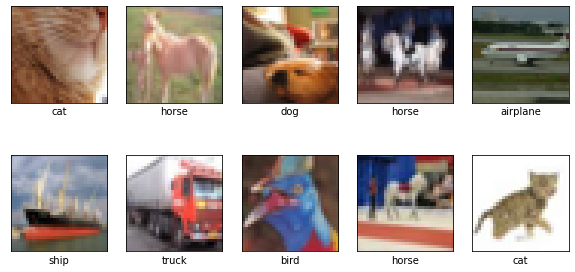

In [ ]:
print('Before Augmentation')
show_images(X_train, y_train, classes=classes)

After Augmentation


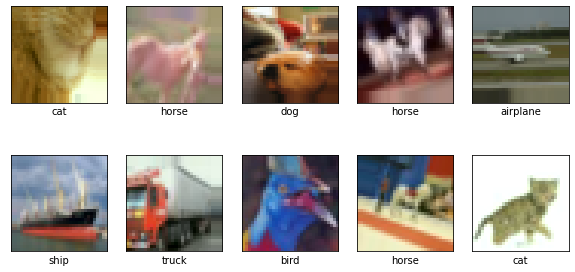

In [ ]:
print('After Augmentation')
for X_aug in tta_datagen.flow_without_labels(X_train[:10], batch_size=10):
    show_images(X_aug, y_train[:10], classes=classes)
    break

validation results

without TTA
loss: 0.19469475746154785 acc: 0.9416999816894531

with TTA
loss: 0.1635119 acc: 0.9522


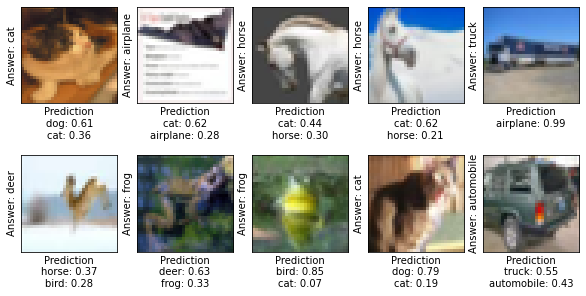

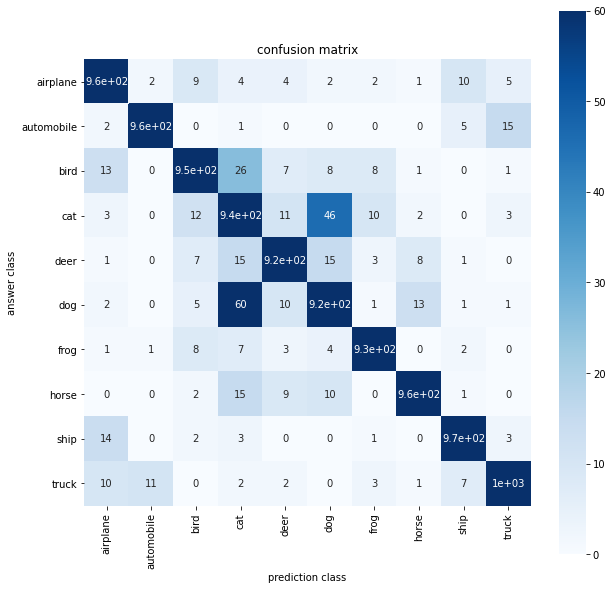

CPU times: user 40.3 s, sys: 1.13 s, total: 41.5 s
Wall time: 34 s


In [ ]:
%%time

print('validation results')

print('\nwithout TTA')
loss, acc = model.evaluate(X_valid, y_valid, verbose=0)
print('loss:', loss, 'acc:', acc)

print('\nwith TTA')

batch_size = 100
steps = X_valid.shape[0] // batch_size
assert batch_size * steps == X_valid.shape[0]

datagen_flow = tta_datagen.flow_without_labels(X_valid, batch_size=batch_size)
y_pred = test_time_augmentation(model, datagen_flow, steps, epochs=20)
calculate_loss_and_acc(y_valid, y_pred)
show_mistaken_images(X_valid, y_valid, y_pred, classes)
plot_confusion_matrix(y_valid, y_pred, classes)

# Calculate test loss and accuracy

In [ ]:
print('test results')

batch_size = 100
steps = X_test.shape[0] // batch_size
assert batch_size * steps == X_test.shape[0]

datagen_flow = tta_datagen.flow_without_labels(X_test, batch_size=batch_size)
y_pred = test_time_augmentation(model, datagen_flow, steps, epochs=20)
calculate_loss_and_acc(y_test, y_pred)

test results
loss: 0.16813645 acc: 0.9526
